In [5]:
%matplotlib inline
import os
import csv
import regex
import pickle
import pymystem3
import itertools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lxml import etree

In [6]:
from tqdm import tqdm_notebook
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
token_regexp = regex.compile("(?u)\\b(\\p{L}+|\d+)\\b")

def tokenize(text):
    return token_regexp.findall(text)

In [8]:
stemmer = pymystem3.Mystem()

add_unparsed = True
gr_regexp = regex.compile("[^\w]")

def lemmatize(tokens):
    lemmas = []
    tokens_str = " ".join(tokens)
    for res in stemmer.analyze(tokens_str):
        if res.get("analysis"):
            info = res["analysis"][0]
            #stem_pos, *_ = gr_regexp.split(info["gr"].upper())
            #lemmas.append("%s_%s" % (info["lex"], mystem_to_uni_map.get(stem_pos, "X")))
            lemmas.append(info["lex"].strip())
        elif add_unparsed:
            lemmas.append(res["text"].strip())
    return list(filter(None, lemmas))

## Train

In [9]:
data_dir = "../data/text_alignment/"
task_name = ""

In [10]:
%%time

files_sentences_ids = {}
sents_cnt = 0

paths = collections.OrderedDict()
with open(data_dir + "tasks/%s/pairs" % task_name) as fin:
    for line in fin:
        susp_name, src_name = line.strip().split()
        paths["susp/" + susp_name] = 1
        paths["src/" + src_name] = 1
paths = list(paths.keys())

with open("dialog.sent2vec.train.txt", "w") as fout:
    for path in tqdm_notebook(paths):
        need_to_continue = False
        lines = []
        with open(data_dir + path) as file:
            for line in file:
                line = line.strip().lower()
                tokens = tokenize(line)
                lines.append(tokens)
        files_sentences_ids[path] = []
        for i, line in enumerate(lines):
            lemmas = lemmatize(line)
            if lemmas:
                fout.write("%s\n" % " ".join(lemmas))
                files_sentences_ids[path].append((sents_cnt, i))
                sents_cnt += 1


CPU times: user 5min 3s, sys: 21.8 s, total: 5min 25s
Wall time: 25min 12s


In [11]:
%%time

!./sent2vec sent2vec -input dialog.sent2vec.train.txt -output dialog.sent2vec -minCount 2 \
                     -dim 100 -wordNgrams 2 -epoch 50 -lr 0.5

Read 33M words
Number of words:  307125
Number of labels: 0
terminate called after throwing an instance of 'std::bad_alloc'
  what():  std::bad_alloc
CPU times: user 227 ms, sys: 57 ms, total: 284 ms
Wall time: 7.18 s


## How well train set is fit

In [26]:
%%time

sentences_cnt = 0
sentences_pairs_list = []

with open("train_texts.csv") as csv_file, open("sent2vec.test.txt", "w") as out_test_file:
    header = csv_file.readline().strip().split(",")
    header[0] = "id"
    csv_reader = csv.DictReader(csv_file, header)
    for row in tqdm_notebook(csv_reader):
        susp_text = lemmatize(tokenize(row["suspicious_text"].strip().lower()))
        src_text = lemmatize(tokenize(row["source_text"].strip().lower()))
        out_test_file.write("%s\n%s\n" % (" ".join(susp_text), " ".join(src_text)))
        sentences_pairs_list.append((sentences_cnt, sentences_cnt + 1))
        sentences_cnt += 2


CPU times: user 4.99 s, sys: 377 ms, total: 5.36 s
Wall time: 24.4 s


In [27]:
%%time

sentences_list = []

sv_out = !./sent2vec print-sentence-vectors sent2vec.bin < sent2vec.test.txt
for line in sv_out:
    sentences_list.append(np.array(list(map(float, line.strip().split(" ")))))
del sv_out

CPU times: user 1.42 s, sys: 163 ms, total: 1.59 s
Wall time: 4.71 s


In [28]:
negative_sample_size = 100

In [29]:
%%time

np.random.seed(1)

clf_train = []
results_list = []

for sentence_pair in tqdm_notebook(sentences_pairs_list):
    question_id = sentence_pair[0]
    question = sentences_list[question_id]
    positive_sample_id = sentence_pair[1]
    positive_sample = sentences_list[positive_sample_id]
    negative_samples_ids = set()
    while True:
        sample_id = np.random.choice(len(sentences_list))
        if sample_id not in negative_samples_ids and sample_id not in sentence_pair:
            negative_samples_ids.add(sample_id)
        if len(negative_samples_ids) == negative_sample_size:
            break
    negative_samples = list(map(sentences_list.__getitem__, negative_samples_ids))
    dists = 1 - cosine_similarity([question], [positive_sample] + negative_samples)[0]
    ranks = sorted(range(len(dists)), key=dists.__getitem__)
    res = ranks.index(0)
    results_list.append(res)
    clf_train.append((dists[ranks[0]], res == 0))


CPU times: user 1min 14s, sys: 0 ns, total: 1min 14s
Wall time: 20.6 s


In [30]:
ks = [1, 5, 10]
results_all_ranks = np.array(results_list)

print("Mean ranking: %.3f" % np.mean(results_all_ranks))

for k in ks:
    ndcg = np.mean(1 / np.log2(np.where(results_all_ranks <= k - 1, results_all_ranks, np.inf) + 2))
    hits = len(results_all_ranks[results_all_ranks <= k - 1]) / len(results_all_ranks)
    print("nDCG@%2d: %.3f | Hits@%2d: %.3f" % (k, ndcg, k, hits))

Mean ranking: 0.847
nDCG@ 1: 0.957 | Hits@ 1: 0.957
nDCG@ 5: 0.969 | Hits@ 5: 0.978
nDCG@10: 0.970 | Hits@10: 0.983


### Error analysis

In [31]:
def show_texts(plag_id):
    obj = test_df.loc[plag_id]
    print("Plagiat type:", obj["obfuscation"])
    print("susp/" + obj["suspicious_path"] + " : " + repr(obj["suspicious_text"]))
    print("src/"+ obj["source_path"] + " : " + repr(obj["source_text"]))

## How well text alignment performs

In [32]:
%%time

!./sent2vec print-sentence-vectors sent2vec.bin < sent2vec.train.txt > vectors.txt

CPU times: user 266 ms, sys: 19 ms, total: 285 ms
Wall time: 9.95 s


In [33]:
%%time

all_vectors = []

with open("vectors.txt") as fin:
    for line in fin:
        all_vectors.append(list(map(float, line.strip().split(" "))))

all_vectors = np.array(all_vectors)

CPU times: user 4.71 s, sys: 195 ms, total: 4.91 s
Wall time: 4.91 s


In [34]:
clf_train_df = pd.DataFrame(clf_train, columns=["sent2vec_dist", "y"])

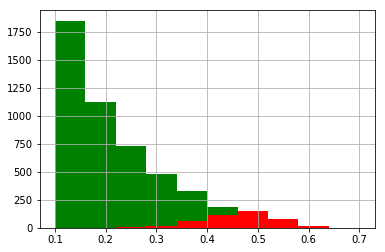

In [35]:
clf_train_df[clf_train_df["y"] == 1]["sent2vec_dist"].hist(color="g", range=(0.1, 0.7))
clf_train_df[clf_train_df["y"] == 0]["sent2vec_dist"].hist(color="r", range=(0.1, 0.7))

In [37]:
%%time

threshold = 0.2
detections = []

for line in tqdm_notebook(open("tasks/pairs")):
    all_metrics = []
    ijs = []
    ds = []
    susp_file, src_file = line.split()
    susp_path = os.path.join("susp", susp_file)
    src_path = os.path.join("src", src_file)
    susp_lens = np.cumsum([0] + list(map(len, open(susp_path).readlines())))
    src_lens = np.cumsum([0] + list(map(len, open(src_path).readlines())))
    susp_ids = files_sentences_ids[susp_path]
    src_ids = files_sentences_ids[src_path]
    susp_vectors = all_vectors[min(susp_ids)[0]:max(susp_ids)[0] + 1]
    src_vectors = all_vectors[min(src_ids)[0]:max(src_ids)[0] + 1]
    sim = 1 - cosine_similarity(susp_vectors, src_vectors)
    for i2, j2 in zip(*np.where(sim < threshold)): # TODO: rework this idea completely !!!
        i = susp_ids[i2][1]
        j = src_ids[j2][1]
        #print(i, j)
        #print(sentences[susp_path][i])
        #print(sentences[src_path][j])
        #print(sim[i2][j2])
        ds.append(((src_lens[j], src_lens[j + 1] - 1), (susp_lens[i], susp_lens[i + 1] - 1)))
    detections.append(ds)


CPU times: user 3.63 s, sys: 219 ms, total: 3.85 s
Wall time: 1.23 s


In [38]:
%time pickle.dump(detections, open("detections.dump", "wb"))

CPU times: user 225 ms, sys: 2 ms, total: 227 ms
Wall time: 226 ms


---